In [1]:
# Import các thư viện cần thiết cho việc xây dựng model
# Ở đây ta sẽ dùng Cuda cho việc xây model trên GPU
# Dùng tensorboard để trực quan hóa và theo dõi các chỉ số quá trình huấn luyện

import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


######################################################
################### TENSORBOARD ######################
######################################################

writer = SummaryWriter('runs/Flowers')

######################################################

cuda


In [2]:
transform = transforms.Compose([
        transforms.RandomRotation(10), #  xoay ngẫu nhiên ảnh với góc quay trong khoảng từ -10 đến 10 độ      
        transforms.RandomHorizontalFlip(), #  lật ngang ảnh theo chiều ngang với xác suất 50%
        transforms.Resize(54), # thay đổi kích thước bên ngắn nhất thành 54 pixel             
        transforms.CenterCrop(54), # cắt kích thước bên dài nhất ra khoảng 54 pixel từ trung tâm        
        transforms.ToTensor(), # Chuyển ma trận ảnh sang dạng tensor thì mới xây dựng được model bằng pytorch
        transforms.Normalize([0.485, 0.456, 0.406], # để chuẩn hoá giá trị của ảnh  
                             [0.229, 0.224, 0.225]) # với giá trị trung bình và độ lệch chuẩn của các kênh màu trong ảnh
])

class FlowersDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None):
        self.data = datasets.ImageFolder(root, transform=transform)
        self.classes = self.data.classes
        self.num_classes = len(self.classes)

    def __getitem__(self, index):
        img, label = self.data[index]
        one_hot_label = F.one_hot(torch.tensor(label), num_classes=self.num_classes).float()# Áp dụng one hot cho label
        return img, one_hot_label

    def __len__(self):
        return len(self.data)
    
    
x_train = FlowersDataset(root=("/kaggle/input/flower-s/FLOWERS/Train"), transform = transform)
x_val = FlowersDataset(root = ('/kaggle/input/flower-s/FLOWERS/Valid'), transform = transform)

In [3]:
class_name = x_train.classes
print("Tổng class: ",len(class_name))
print("Tên các loại: ",class_name)

Tổng class:  5
Tên các loại:  ['Apricots', 'Daisy', 'Lotus', 'Pink', 'Waterlily']


In [4]:
batch = 128 # Khai báo kích thước batch
epochs = 80 # Thực hiện 80 epochs
learning_rate = 1e-3 # Khao báo tốc độ học là 10^(-3)
weight_decay = 1e-4 # Khai báo weight decay là 10^(-4) để giảm thiểu overfitting

# Chuyển đổi dataset thành iterable có thể duyệt qua theo batch size 
train_loader = DataLoader(x_train, batch_size = batch, shuffle = True)
val_loader = DataLoader(x_val, batch_size = batch, shuffle = True)


# Ví dụ
examples = iter(val_loader)
example_data, example_targets = next(examples)


# Chuyển đổi kênh màu từ BGR sang RGB
example_data_rgb = example_data[:, [2, 1, 0], :, :]


######################################################
################### TENSORBOARD ######################
######################################################

# Tạo grid ảnh
img_grid = torchvision.utils.make_grid(example_data_rgb, nrow=8)

writer.add_image("Flower",img_grid)
writer.close()

######################################################

In [5]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.maxpool = nn.MaxPool2d(kernel_size = 2, stride = 2)
    self.conv1 = nn.Conv2d(3,32,3,stride = 1, padding = 2)
    self.conv2 = nn.Conv2d(32,64,3,stride = 1, padding = 1)
    self.conv3 = nn.Conv2d(64,128,3,stride = 1, padding = 1)
    self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
    self.dropout = nn.Dropout(p = 0.1)
    self.fc1 = nn.Linear(7*7*128, 124)
    self.fc2 = nn.Linear(124,32)
    self.fc3 = nn.Linear(32, 6)
    
  def forward(self, x):
    x = self.maxpool(F.leaky_relu(self.conv1(x)))
    x = self.maxpool(F.leaky_relu(self.conv2(x)))
    x = self.maxpool(F.leaky_relu(self.conv3(x)))
    x = self.avgpool(x)
    x = x.view(-1, 7*7*128)
    x = self.dropout(F.leaky_relu(self.fc1(x)))
    x = self.dropout(F.leaky_relu(self.fc2(x)))
    x = self.fc3(x)

    return x

model = CNN().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = weight_decay)

######################################################
################### TENSORBOARD ######################
######################################################

writer.add_graph(model, example_data.to(device))
writer.close()

######################################################

In [6]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: 
            continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

count_parameters(model)

+--------------+------------+
|   Modules    | Parameters |
+--------------+------------+
| conv1.weight |    864     |
|  conv1.bias  |     32     |
| conv2.weight |   18432    |
|  conv2.bias  |     64     |
| conv3.weight |   73728    |
|  conv3.bias  |    128     |
|  fc1.weight  |   777728   |
|   fc1.bias   |    124     |
|  fc2.weight  |    3968    |
|   fc2.bias   |     32     |
|  fc3.weight  |    192     |
|   fc3.bias   |     6      |
+--------------+------------+
Total Trainable Params: 875298


875298

In [7]:
n_total_steps = len(train_loader)

run_loss = 0.0
run_acc = 0.0
for epoch in range(epochs):
    for i, (images, labels) in enumerate(tqdm(train_loader)):
        images = images.reshape(-1,3,54,54).to(device)
        labels = labels.to(device)
        _, labels = torch.max(labels.data, 1)

        outputs = model(images)

        loss = criterion(outputs,labels)
        
        run_loss +=loss.item() #for tensorboard
        _,pred = torch.max(outputs.data, 1)
        run_acc += (pred==labels).sum().item()#for tensorboard
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 3 == 0:
            
            ############################## Check validation_data ###################################
            with torch.no_grad():
                n_correct = 0
                n_samples = 0
                n_class_correct = [0 for i in range(5)]
                n_class_samples = [0 for i in range(5)]
                
                for images_val, labels_val in val_loader:
                    images_val = images_val.reshape(-1,3,54,54).to(device)
                    labels_val = labels_val.to(device)
                    _, labels_val = torch.max(labels_val.data, 1)
                    
                    output_val = model(images_val)
                    _, predict_val = torch.max(output_val.data, 1)
                    n_samples += labels_val.size(0)
                    n_correct += (predict_val == labels_val).sum().item()
                    loss_val = F.mse_loss(labels_val.float(),predict_val.float())
                    for i in range(26):
                        label_val = labels_val[i]
                        pred_val = predict_val[i]
                        if label_val == pred_val:
                            n_class_correct[label_val] += 1
                            
                        n_class_samples[label_val] += 1
                        
                acc_val = n_correct/(n_samples)
                run_acc_total = run_acc/((3-1)*128+pred.size(0))
                
                print(f'Epoch[{epoch+1}/{epochs}]:  Loss of Train: {(run_loss/3):.2f}, Accuracy of Train: {run_acc_total:.2f},Loss of Val: {loss_val:.2f} , Acc of Val: {acc_val:.2f}')
            
            
            ################################################################################################################
            #################################################### TENSORBOARD ###############################################
            ################################################################################################################           
            writer.add_scalars("Mất mát:   ", {'Loss_train': run_loss/3, 'Loss_valid':loss_val}, epoch*n_total_steps+i)
            writer.add_scalars('Chính xác:   ', {'Accuracy_trrain':run_acc_total,'Accuracy_valid':acc_val}, epoch*n_total_steps+i)
            
            run_loss = 0.0
            run_acc = 0.0
            ################################################################################################################           

print('Finished Training')

100%|██████████| 3/3 [00:06<00:00,  2.05s/it]


Epoch[1/80]:  Loss of Train: 1.67, Accuracy of Train: 0.32,Loss of Val: 1.54 , Acc of Val: 0.27


100%|██████████| 3/3 [00:05<00:00,  1.85s/it]


Epoch[2/80]:  Loss of Train: 1.48, Accuracy of Train: 0.36,Loss of Val: 2.08 , Acc of Val: 0.38


100%|██████████| 3/3 [00:05<00:00,  1.86s/it]


Epoch[3/80]:  Loss of Train: 1.39, Accuracy of Train: 0.35,Loss of Val: 2.27 , Acc of Val: 0.35


100%|██████████| 3/3 [00:05<00:00,  1.79s/it]


Epoch[4/80]:  Loss of Train: 1.40, Accuracy of Train: 0.40,Loss of Val: 1.46 , Acc of Val: 0.69


100%|██████████| 3/3 [00:05<00:00,  1.89s/it]


Epoch[5/80]:  Loss of Train: 1.30, Accuracy of Train: 0.45,Loss of Val: 1.65 , Acc of Val: 0.65


100%|██████████| 3/3 [00:05<00:00,  1.83s/it]


Epoch[6/80]:  Loss of Train: 1.26, Accuracy of Train: 0.48,Loss of Val: 1.77 , Acc of Val: 0.65


100%|██████████| 3/3 [00:06<00:00,  2.03s/it]


Epoch[7/80]:  Loss of Train: 1.15, Accuracy of Train: 0.52,Loss of Val: 1.46 , Acc of Val: 0.62


100%|██████████| 3/3 [00:05<00:00,  1.85s/it]


Epoch[8/80]:  Loss of Train: 1.15, Accuracy of Train: 0.56,Loss of Val: 0.54 , Acc of Val: 0.58


100%|██████████| 3/3 [00:05<00:00,  1.89s/it]


Epoch[9/80]:  Loss of Train: 1.03, Accuracy of Train: 0.61,Loss of Val: 0.96 , Acc of Val: 0.65


100%|██████████| 3/3 [00:05<00:00,  1.87s/it]


Epoch[10/80]:  Loss of Train: 1.07, Accuracy of Train: 0.62,Loss of Val: 1.31 , Acc of Val: 0.69


100%|██████████| 3/3 [00:05<00:00,  1.81s/it]


Epoch[11/80]:  Loss of Train: 0.92, Accuracy of Train: 0.61,Loss of Val: 0.46 , Acc of Val: 0.77


100%|██████████| 3/3 [00:05<00:00,  2.00s/it]


Epoch[12/80]:  Loss of Train: 0.88, Accuracy of Train: 0.69,Loss of Val: 1.54 , Acc of Val: 0.65


100%|██████████| 3/3 [00:05<00:00,  1.81s/it]


Epoch[13/80]:  Loss of Train: 0.89, Accuracy of Train: 0.66,Loss of Val: 0.62 , Acc of Val: 0.81


100%|██████████| 3/3 [00:05<00:00,  1.80s/it]


Epoch[14/80]:  Loss of Train: 0.91, Accuracy of Train: 0.70,Loss of Val: 1.08 , Acc of Val: 0.77


100%|██████████| 3/3 [00:05<00:00,  1.89s/it]


Epoch[15/80]:  Loss of Train: 0.83, Accuracy of Train: 0.69,Loss of Val: 1.54 , Acc of Val: 0.77


100%|██████████| 3/3 [00:05<00:00,  1.81s/it]


Epoch[16/80]:  Loss of Train: 0.73, Accuracy of Train: 0.72,Loss of Val: 0.50 , Acc of Val: 0.73


100%|██████████| 3/3 [00:05<00:00,  1.82s/it]


Epoch[17/80]:  Loss of Train: 0.74, Accuracy of Train: 0.73,Loss of Val: 1.31 , Acc of Val: 0.69


100%|██████████| 3/3 [00:06<00:00,  2.01s/it]


Epoch[18/80]:  Loss of Train: 0.72, Accuracy of Train: 0.73,Loss of Val: 0.73 , Acc of Val: 0.81


100%|██████████| 3/3 [00:05<00:00,  1.89s/it]


Epoch[19/80]:  Loss of Train: 0.67, Accuracy of Train: 0.72,Loss of Val: 1.23 , Acc of Val: 0.62


100%|██████████| 3/3 [00:05<00:00,  1.80s/it]


Epoch[20/80]:  Loss of Train: 0.68, Accuracy of Train: 0.74,Loss of Val: 0.46 , Acc of Val: 0.77


100%|██████████| 3/3 [00:05<00:00,  1.84s/it]


Epoch[21/80]:  Loss of Train: 0.61, Accuracy of Train: 0.78,Loss of Val: 0.62 , Acc of Val: 0.73


100%|██████████| 3/3 [00:05<00:00,  1.85s/it]


Epoch[22/80]:  Loss of Train: 0.55, Accuracy of Train: 0.76,Loss of Val: 0.77 , Acc of Val: 0.77


100%|██████████| 3/3 [00:05<00:00,  1.83s/it]


Epoch[23/80]:  Loss of Train: 0.63, Accuracy of Train: 0.75,Loss of Val: 0.85 , Acc of Val: 0.69


100%|██████████| 3/3 [00:05<00:00,  1.99s/it]


Epoch[24/80]:  Loss of Train: 0.59, Accuracy of Train: 0.78,Loss of Val: 0.85 , Acc of Val: 0.73


100%|██████████| 3/3 [00:05<00:00,  1.85s/it]


Epoch[25/80]:  Loss of Train: 0.50, Accuracy of Train: 0.80,Loss of Val: 0.85 , Acc of Val: 0.81


100%|██████████| 3/3 [00:05<00:00,  1.87s/it]


Epoch[26/80]:  Loss of Train: 0.48, Accuracy of Train: 0.84,Loss of Val: 0.54 , Acc of Val: 0.81


100%|██████████| 3/3 [00:05<00:00,  1.79s/it]


Epoch[27/80]:  Loss of Train: 0.49, Accuracy of Train: 0.84,Loss of Val: 0.42 , Acc of Val: 0.81


100%|██████████| 3/3 [00:05<00:00,  1.85s/it]


Epoch[28/80]:  Loss of Train: 0.41, Accuracy of Train: 0.84,Loss of Val: 1.19 , Acc of Val: 0.77


100%|██████████| 3/3 [00:06<00:00,  2.05s/it]


Epoch[29/80]:  Loss of Train: 0.46, Accuracy of Train: 0.82,Loss of Val: 0.38 , Acc of Val: 0.85


100%|██████████| 3/3 [00:05<00:00,  1.77s/it]


Epoch[30/80]:  Loss of Train: 0.43, Accuracy of Train: 0.85,Loss of Val: 0.77 , Acc of Val: 0.77


100%|██████████| 3/3 [00:05<00:00,  1.79s/it]


Epoch[31/80]:  Loss of Train: 0.43, Accuracy of Train: 0.85,Loss of Val: 0.88 , Acc of Val: 0.77


100%|██████████| 3/3 [00:05<00:00,  1.85s/it]


Epoch[32/80]:  Loss of Train: 0.46, Accuracy of Train: 0.84,Loss of Val: 0.92 , Acc of Val: 0.73


100%|██████████| 3/3 [00:05<00:00,  1.78s/it]


Epoch[33/80]:  Loss of Train: 0.44, Accuracy of Train: 0.85,Loss of Val: 0.85 , Acc of Val: 0.73


100%|██████████| 3/3 [00:05<00:00,  1.77s/it]


Epoch[34/80]:  Loss of Train: 0.49, Accuracy of Train: 0.82,Loss of Val: 0.92 , Acc of Val: 0.77


100%|██████████| 3/3 [00:06<00:00,  2.03s/it]


Epoch[35/80]:  Loss of Train: 0.38, Accuracy of Train: 0.92,Loss of Val: 0.73 , Acc of Val: 0.73


100%|██████████| 3/3 [00:05<00:00,  1.77s/it]


Epoch[36/80]:  Loss of Train: 0.37, Accuracy of Train: 0.85,Loss of Val: 0.35 , Acc of Val: 0.88


100%|██████████| 3/3 [00:05<00:00,  1.88s/it]


Epoch[37/80]:  Loss of Train: 0.44, Accuracy of Train: 0.82,Loss of Val: 0.58 , Acc of Val: 0.77


100%|██████████| 3/3 [00:05<00:00,  1.79s/it]


Epoch[38/80]:  Loss of Train: 0.29, Accuracy of Train: 0.90,Loss of Val: 0.62 , Acc of Val: 0.73


100%|██████████| 3/3 [00:05<00:00,  1.79s/it]


Epoch[39/80]:  Loss of Train: 0.28, Accuracy of Train: 0.91,Loss of Val: 0.46 , Acc of Val: 0.77


100%|██████████| 3/3 [00:05<00:00,  1.74s/it]


Epoch[40/80]:  Loss of Train: 0.36, Accuracy of Train: 0.88,Loss of Val: 0.69 , Acc of Val: 0.77


100%|██████████| 3/3 [00:05<00:00,  1.93s/it]


Epoch[41/80]:  Loss of Train: 0.30, Accuracy of Train: 0.89,Loss of Val: 0.62 , Acc of Val: 0.85


100%|██████████| 3/3 [00:05<00:00,  1.80s/it]


Epoch[42/80]:  Loss of Train: 0.19, Accuracy of Train: 0.94,Loss of Val: 0.69 , Acc of Val: 0.85


100%|██████████| 3/3 [00:05<00:00,  1.82s/it]


Epoch[43/80]:  Loss of Train: 0.26, Accuracy of Train: 0.93,Loss of Val: 0.19 , Acc of Val: 0.92


100%|██████████| 3/3 [00:05<00:00,  1.78s/it]


Epoch[44/80]:  Loss of Train: 0.25, Accuracy of Train: 0.91,Loss of Val: 0.50 , Acc of Val: 0.85


100%|██████████| 3/3 [00:05<00:00,  1.83s/it]


Epoch[45/80]:  Loss of Train: 0.16, Accuracy of Train: 0.95,Loss of Val: 0.54 , Acc of Val: 0.88


100%|██████████| 3/3 [00:05<00:00,  1.83s/it]


Epoch[46/80]:  Loss of Train: 0.16, Accuracy of Train: 0.93,Loss of Val: 0.50 , Acc of Val: 0.85


100%|██████████| 3/3 [00:05<00:00,  1.95s/it]


Epoch[47/80]:  Loss of Train: 0.16, Accuracy of Train: 0.95,Loss of Val: 0.19 , Acc of Val: 0.92


100%|██████████| 3/3 [00:05<00:00,  1.86s/it]


Epoch[48/80]:  Loss of Train: 0.14, Accuracy of Train: 0.95,Loss of Val: 0.12 , Acc of Val: 0.88


100%|██████████| 3/3 [00:05<00:00,  1.80s/it]


Epoch[49/80]:  Loss of Train: 0.18, Accuracy of Train: 0.93,Loss of Val: 0.58 , Acc of Val: 0.85


100%|██████████| 3/3 [00:05<00:00,  1.74s/it]


Epoch[50/80]:  Loss of Train: 0.14, Accuracy of Train: 0.94,Loss of Val: 0.38 , Acc of Val: 0.85


100%|██████████| 3/3 [00:05<00:00,  1.82s/it]


Epoch[51/80]:  Loss of Train: 0.14, Accuracy of Train: 0.95,Loss of Val: 0.12 , Acc of Val: 0.88


100%|██████████| 3/3 [00:05<00:00,  1.99s/it]


Epoch[52/80]:  Loss of Train: 0.15, Accuracy of Train: 0.96,Loss of Val: 0.54 , Acc of Val: 0.81


100%|██████████| 3/3 [00:05<00:00,  1.81s/it]


Epoch[53/80]:  Loss of Train: 0.10, Accuracy of Train: 0.97,Loss of Val: 0.27 , Acc of Val: 0.85


100%|██████████| 3/3 [00:05<00:00,  1.75s/it]


Epoch[54/80]:  Loss of Train: 0.12, Accuracy of Train: 0.95,Loss of Val: 0.54 , Acc of Val: 0.81


100%|██████████| 3/3 [00:05<00:00,  1.74s/it]


Epoch[55/80]:  Loss of Train: 0.10, Accuracy of Train: 0.96,Loss of Val: 0.50 , Acc of Val: 0.85


100%|██████████| 3/3 [00:05<00:00,  1.79s/it]


Epoch[56/80]:  Loss of Train: 0.10, Accuracy of Train: 0.96,Loss of Val: 0.08 , Acc of Val: 0.92


100%|██████████| 3/3 [00:05<00:00,  1.84s/it]


Epoch[57/80]:  Loss of Train: 0.08, Accuracy of Train: 0.98,Loss of Val: 0.38 , Acc of Val: 0.92


100%|██████████| 3/3 [00:05<00:00,  1.87s/it]


Epoch[58/80]:  Loss of Train: 0.07, Accuracy of Train: 0.97,Loss of Val: 0.77 , Acc of Val: 0.77


100%|██████████| 3/3 [00:05<00:00,  1.81s/it]


Epoch[59/80]:  Loss of Train: 0.06, Accuracy of Train: 0.99,Loss of Val: 0.35 , Acc of Val: 0.96


100%|██████████| 3/3 [00:05<00:00,  1.81s/it]


Epoch[60/80]:  Loss of Train: 0.06, Accuracy of Train: 0.99,Loss of Val: 0.35 , Acc of Val: 0.88


100%|██████████| 3/3 [00:05<00:00,  1.80s/it]


Epoch[61/80]:  Loss of Train: 0.05, Accuracy of Train: 0.99,Loss of Val: 0.35 , Acc of Val: 0.96


100%|██████████| 3/3 [00:05<00:00,  1.77s/it]


Epoch[62/80]:  Loss of Train: 0.05, Accuracy of Train: 0.98,Loss of Val: 0.19 , Acc of Val: 0.92


100%|██████████| 3/3 [00:05<00:00,  1.79s/it]


Epoch[63/80]:  Loss of Train: 0.05, Accuracy of Train: 0.98,Loss of Val: 0.19 , Acc of Val: 0.92


100%|██████████| 3/3 [00:05<00:00,  1.97s/it]


Epoch[64/80]:  Loss of Train: 0.04, Accuracy of Train: 0.98,Loss of Val: 0.19 , Acc of Val: 0.92


100%|██████████| 3/3 [00:05<00:00,  1.84s/it]


Epoch[65/80]:  Loss of Train: 0.05, Accuracy of Train: 0.99,Loss of Val: 0.23 , Acc of Val: 0.88


100%|██████████| 3/3 [00:05<00:00,  1.74s/it]


Epoch[66/80]:  Loss of Train: 0.05, Accuracy of Train: 0.99,Loss of Val: 0.04 , Acc of Val: 0.96


100%|██████████| 3/3 [00:05<00:00,  1.83s/it]


Epoch[67/80]:  Loss of Train: 0.05, Accuracy of Train: 0.98,Loss of Val: 0.15 , Acc of Val: 0.96


100%|██████████| 3/3 [00:05<00:00,  1.82s/it]


Epoch[68/80]:  Loss of Train: 0.06, Accuracy of Train: 0.98,Loss of Val: 0.27 , Acc of Val: 0.85


100%|██████████| 3/3 [00:05<00:00,  1.78s/it]


Epoch[69/80]:  Loss of Train: 0.04, Accuracy of Train: 1.00,Loss of Val: 0.69 , Acc of Val: 0.77


100%|██████████| 3/3 [00:05<00:00,  1.98s/it]


Epoch[70/80]:  Loss of Train: 0.08, Accuracy of Train: 0.97,Loss of Val: 0.73 , Acc of Val: 0.81


100%|██████████| 3/3 [00:05<00:00,  1.91s/it]


Epoch[71/80]:  Loss of Train: 0.06, Accuracy of Train: 0.99,Loss of Val: 0.35 , Acc of Val: 0.88


100%|██████████| 3/3 [00:05<00:00,  1.82s/it]


Epoch[72/80]:  Loss of Train: 0.03, Accuracy of Train: 0.99,Loss of Val: 0.42 , Acc of Val: 0.81


100%|██████████| 3/3 [00:05<00:00,  1.79s/it]


Epoch[73/80]:  Loss of Train: 0.08, Accuracy of Train: 0.97,Loss of Val: 0.54 , Acc of Val: 0.88


100%|██████████| 3/3 [00:05<00:00,  1.80s/it]


Epoch[74/80]:  Loss of Train: 0.05, Accuracy of Train: 0.98,Loss of Val: 0.19 , Acc of Val: 0.92


100%|██████████| 3/3 [00:06<00:00,  2.05s/it]


Epoch[75/80]:  Loss of Train: 0.06, Accuracy of Train: 0.97,Loss of Val: 0.15 , Acc of Val: 0.96


100%|██████████| 3/3 [00:05<00:00,  1.78s/it]


Epoch[76/80]:  Loss of Train: 0.07, Accuracy of Train: 0.99,Loss of Val: 0.23 , Acc of Val: 0.88


100%|██████████| 3/3 [00:05<00:00,  1.80s/it]


Epoch[77/80]:  Loss of Train: 0.09, Accuracy of Train: 0.98,Loss of Val: 0.42 , Acc of Val: 0.81


100%|██████████| 3/3 [00:05<00:00,  1.80s/it]


Epoch[78/80]:  Loss of Train: 0.10, Accuracy of Train: 0.97,Loss of Val: 0.50 , Acc of Val: 0.92


100%|██████████| 3/3 [00:05<00:00,  1.82s/it]


Epoch[79/80]:  Loss of Train: 0.06, Accuracy of Train: 0.98,Loss of Val: 0.73 , Acc of Val: 0.81


100%|██████████| 3/3 [00:05<00:00,  1.72s/it]

Epoch[80/80]:  Loss of Train: 0.07, Accuracy of Train: 0.97,Loss of Val: 0.69 , Acc of Val: 0.85
Finished Training


In [8]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(5)]
    n_class_samples = [0 for i in range(5)]
    
    for images, labels in val_loader:
        images = images.reshape(-1,3,54,54).to(device)
        labels = labels.to(device)
        _, labels = torch.max(labels.data, 1)

        output = model(images)
        
        _, predict = torch.max(output.data, 1)
        n_samples += labels.size(0)
        n_correct += (predict == labels).sum().item()
        
        for i in range(26):
            label = labels[i]
            pred = predict[i]
            if label == pred:
                n_class_correct[label] +=1
                
            n_class_samples[label]+=1
            
    acc = 100.0*n_correct/n_samples
    print(f'Accuracy of the network: {acc} %')

Accuracy of the network: 96.15384615384616 %


In [9]:
# Save model
FILE = "model.pth"
torch.save(model.state_dict(), FILE)


# Load model
loaded_model = CNN().to(device)
loaded_model.load_state_dict(torch.load(FILE)) # it takes the loaded dictionary, not the path file itself
loaded_model.eval()

CNN(
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (avgpool): AdaptiveAvgPool2d(output_size=(7, 7))
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=6272, out_features=124, bias=True)
  (fc2): Linear(in_features=124, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=6, bias=True)
)

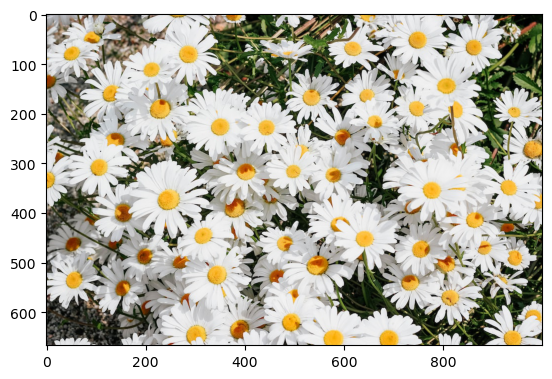

Daisy


In [10]:
from torchvision import transforms
import PIL.Image as Image

url = '/kaggle/input/flower-s/FLOWERS/Test/Daisy.jpg'
# Load ảnh
img = Image.open(url)


# Hiển thị ảnh
plt.imshow(img)
plt.show()
# Áp dụng transform

img_transformed = transform(img)



test = loaded_model(img_transformed.to(device))
print(class_name[torch.max(test.data,1)[1].data])

In [11]:
!zip -r abc.zip /kaggle/working/runs

updating: kaggle/working/runs/ (stored 0%)
updating: kaggle/working/runs/Flowers/ (stored 0%)
updating: kaggle/working/runs/Flowers/events.out.tfevents.1683018597.7c9064f0c51d.23.1 (deflated 84%)
updating: kaggle/working/runs/Flowers/Mất mát:   _Loss_train/ (stored 0%)
updating: kaggle/working/runs/Flowers/Mất mát:   _Loss_train/events.out.tfevents.1683018609.7c9064f0c51d.23.3 (deflated 65%)
updating: kaggle/working/runs/Flowers/Mất mát:   _Loss_valid/ (stored 0%)
updating: kaggle/working/runs/Flowers/Mất mát:   _Loss_valid/events.out.tfevents.1683018609.7c9064f0c51d.23.4 (deflated 68%)
updating: kaggle/working/runs/Flowers/Chính xác:   _Accuracy_valid/ (stored 0%)
updating: kaggle/working/runs/Flowers/Chính xác:   _Accuracy_valid/events.out.tfevents.1683018609.7c9064f0c51d.23.6 (deflated 70%)
updating: kaggle/working/runs/Flowers/events.out.tfevents.1683018591.7c9064f0c51d.23.0 (deflated 0%)
updating: kaggle/working/runs/Flowers/Chính xác:   _Accuracy_trrain/ (stored 0%)
updating: kag